# Quarter Degree Barotropic Streamfunction

In [1]:
%pylab inline

import cosima_cookbook as cc
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import scipy.interpolate
import scipy.ndimage
from tqdm import tqdm_notebook
import IPython.display
import cmocean as cm
from scipy.io import loadmat
from dask.distributed import Client
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.ticker as mticker
import seawater as sw
from gsw import SA_from_SP, p_from_z, CT_from_pt, rho
from gsw import rho
import sys, os

Populating the interactive namespace from numpy and matplotlib


A database is present which has all the required netcdf files and contains all varieties of data like temperature, grid size, etc. db is used to call this database, and a qauarter degree grid is used for doing all the computations.

In [2]:
sys.path.append(os.path.join(os.getcwd(),'ACCESS-OM2-1-025-010deg-report/figures'))
import exptdata
print('Available exptdata keys:',[k for k in exptdata.exptdict.keys()])
db = '/g/data3/hh5/tmp/cosima/database/access-om2.db'
session = cc.database.create_session(db)
ekey = '025deg'
expt = exptdata.exptdict[ekey]['expt']
offset = exptdata.exptdict[ekey]['offset']

Available exptdata keys: ['1deg', '025deg', '01deg']


In [3]:
#Input all data needed from the model for quarter degree

T = cc.querying.getvar(expt,'temp',session,start_time='2000-01-01',end_time='2049-12-31').mean('time')
T_NA = T.sel(xt_ocean=slice(-90,10)).sel(yt_ocean=slice(20,65))
salt = cc.querying.getvar(expt,'salt',session,start_time='2000-01-01',end_time='2049-12-31').mean('time')
salt_NA = salt.sel(xt_ocean=slice(-90,10)).sel(yt_ocean=slice(20,65))
z_t = cc.querying.getvar(expt,'st_ocean',session,n=1)
dz = cc.querying.getvar(expt,'dzt',session,start_time='2000-01-01',end_time='2049-12-31').mean("time")
dz_NA = dz.sel(xt_ocean=slice(-90,10)).sel(yt_ocean=slice(20,65))
z_w = cc.querying.getvar(expt,'sw_ocean',session,n=1)
y_t = cc.querying.getvar(expt,'yt_ocean',session, n=1)
y_t_NA = y_t.sel(yt_ocean=slice(20,65))   #Latitude range for the North Atlantic Ocean
x_t = cc.querying.getvar(expt,'xt_ocean',session, n=1)
x_t_NA = x_t.sel(xt_ocean=slice(-90,10))   #Longitude range for the North Atlantic Ocean
x_u = cc.querying.getvar(expt,'xu_ocean',session, n=1)
x_u_NA = x_u.sel(xu_ocean=slice(-90,10))   #Latitude range for the North Atlantic Ocean
y_u = cc.querying.getvar(expt,'yu_ocean',session, n=1)
y_u_NA = y_u.sel(yu_ocean=slice(20,65))   #Longitude range for the North Atlantic Ocean
u = cc.querying.getvar(expt,'u',session,start_time='2000-01-01',end_time='2049-12-31').mean('time')
v = cc.querying.getvar(expt,'v',session,start_time='2000-01-01',end_time='2049-12-31').mean('time')
u_NA = u.sel(xu_ocean=slice(-90,10)).sel(yu_ocean=slice(20,65))
v_NA = v.sel(xu_ocean=slice(-90,10)).sel(yu_ocean=slice(20,65))
tau_x = cc.querying.getvar(expt,'tau_x',session,start_time='2000-01-01',end_time='2049-12-31').mean('time')
tau_y = cc.querying.getvar(expt,'tau_y',session,start_time='2000-01-01',end_time='2049-12-31').mean('time')
tx_trans=cc.querying.getvar(expt,'tx_trans',session,start_time='2000-01-01',end_time='2049-12-31').mean('time')
tx_trans_NA = tx_trans.sel(xu_ocean=slice(-90,10)).sel(yt_ocean=slice(20,65))
ty_trans= cc.querying.getvar(expt,'ty_trans',session,start_time='2000-01-01',end_time='2049-12-31').mean('time')
ty_trans_NA = ty_trans.sel(xt_ocean=slice(-90,10)).sel(yu_ocean=slice(20,65))
Eta = cc.querying.getvar(expt,'sea_level',session,start_time='2000-01-01',end_time='2049-12-31').mean('time')
Eta_NA = Eta.sel(xt_ocean=slice(-90,10)).sel(yt_ocean=slice(20,65))
dxu = cc.querying.getvar(expt,'dxu',session, n=1)
dyu = cc.querying.getvar(expt,'dyu',session, n=1)

# Calculating Ekman Transport

Colin De Verdiere's paper, (https://journals.ametsoc.org/doi/10.1175/JPO-D-15-0046.1), provides us with a way to calculate the barotropic streamfunction by estimating the Ekman and Geostrophic Transport individually and adding them vectorially.

To calculate the Ekman Transport, the following equation is solved :

$
\begin{equation}
\rho_0 f \hat{k} \times \mathbf{U_E} = \mathbf{\tau}
\end{equation}
$

For the present case, the North Atlantic Ocean is modelled on a 1 degree model, since it is a good area for testing and validation of results. The above equation is solved in a spherical coordinate system.

Wind Stress is taken from the model itself and this vector equation is solved for x and y axes.

In [4]:
#Slicing off the North Atlantic Ocean for tau_x and tau_y

tau_x_NA = tau_x.sel(xu_ocean=slice(-90,10)).sel(yu_ocean=slice(20,65))
tau_y_NA = tau_y.sel(xu_ocean=slice(-90,10)).sel(yu_ocean=slice(20,65))

In [5]:
#Calculating Ekman Transports in x and y directions

rho_nil = 1036
av = 7.2921159 * 10**(-5)
r0 = 6.371 * 10**6
f = 2*av*np.sin((tau_x_NA.yu_ocean*np.pi)/180)  #Coriolis Parameter
Uey = - tau_x_NA/(f*rho_nil)   #Y Ekman Transport
Uex = tau_y_NA/(f*rho_nil)     #X Ekman Transport

#Converting Dataset to DataArray
Uex_Array = xr.DataArray(Uex, coords = [y_u_NA, x_u_NA],  dims = ['yu_ocean', 'xu_ocean'], 
                         name = 'x Direction Ekman Transport', attrs = {'units':'m^2/s'})
Uey_Array = xr.DataArray(Uey, coords = [y_u_NA, x_u_NA],  dims = ['yu_ocean', 'xu_ocean'], 
                         name = 'y Direction Ekman Transport', attrs = {'units':'m^2/s'})

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


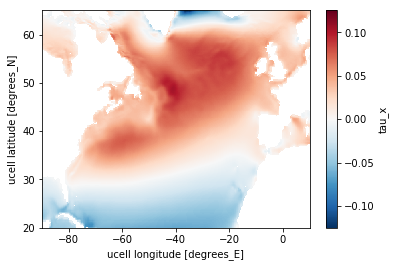

In [6]:
tau_x_NA.plot()

## Geostrophic Transport

After Ekman Transport, the Geostrophic Transport is calculated. There is no direct way to calculate the Geostrophic Transport. Instead, we calculate the Geostrophic velocities first, using the following equation :

\begin{equation}
    f \mathbf{k} \times \rho \mathbf{u_G} = -\nabla{p}
\end{equation}

Pressure can be calculated in two ways:

1. Run the 1 degree ACCESS Model : A simulation of several years of the ACCESS Model is run and the pressure that we get is taken.

2. Use TEOS(Thermal equation of water) : TEOS has several built in funtions to calculate pressure from temperature and salinity. One such function has been used. The catch here is that it requires the density variation, which is unknown. To calculate the density, another function is used which requires salinity, temperature and pressure. The pressure is estimated using the hydrostatic equation, since we know the depth. However, it is not accurate and might lead to errors.  

Once the pressure is calculated, its gradient is calculated and the vector equation is solved independently for the zonal and meridional velocities.

Note : The function in the package seawater, "eos80.dens0(salinity, temperature)" is not correct because it assumes that the gauge pressure is zero, which is only true if we are considering the surface.

### Calculation of Pressure and its gradient from gsw_rho

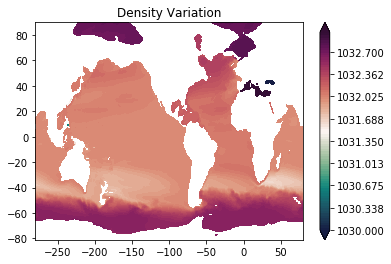

In [7]:
Y,Z,X =  np.meshgrid(y_t,z_t,x_t)
pressure_array = xr.DataArray(p_from_z(-Z,Y),  coords = [z_t, y_t, x_t],  
                              dims = ['st_ocean','yt_ocean', 'xt_ocean'], name = 'pressure', attrs = {'units':'dbar'})
pressure_array_NA = pressure_array.sel(xt_ocean=slice(-90,10)).sel(yt_ocean=slice(20,65))
rho_mat = rho(salt,T-273.15,pressure_array)
levs = np.linspace(1030,1033,81);
cb3 = plt.contourf(T.xt_ocean,T.yt_ocean,rho_mat[28,:,:],levels = levs, cmap = cm.cm.curl, extend = 'both');
plt.colorbar(cb3);
plt.title('Density Variation');

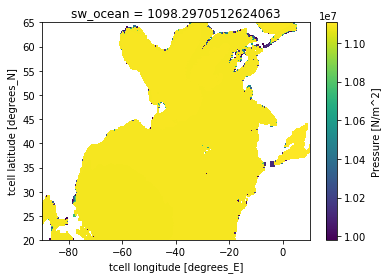

In [8]:
rho_nil = 1036     #Since it is volume conserving model, density is constant everywhere except in calculating pressure

rho_DA = xr.DataArray(rho_mat,  coords = [z_t, y_t, x_t],  dims = ['st_ocean','yt_ocean', 'xt_ocean'], 
                      name = 'pressure', attrs = {'units':'dbar'})
g = 9.81
dP = g*rho_DA*dz_NA
#Surf = rho_nil*g*Eta
mask_arr = xr.ufuncs.isnan(dz_NA)
mask = mask_arr.values
mask = mask.astype(int)
mask = np.where(mask < 0.2,mask,np.nan)
mask = mask + 1
mask_array = xr.DataArray(mask,  coords = [z_t, y_t_NA, x_t_NA], dims = ['st_ocean','yt_ocean', 'xt_ocean'], 
                          name = 'Mask', attrs = {'units':'none'})

P = np.cumsum(dP, axis = 0)
#P = P + Surf
P = P*mask
P_val = P.values
P_sw = xr.DataArray(P_val,  coords = [z_w, y_t_NA, x_t_NA], dims = ['sw_ocean','yt_ocean', 'xt_ocean'], 
                          name = 'Pressure', attrs = {'units':'N/m^2'})
P_sw[28,:,:].plot()

In [9]:
P_sw.xt_ocean.shape

(400,)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less


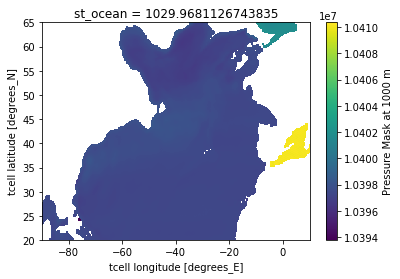

In [10]:
nz = 50
ny = 263
nx = 400
Y,Z,X = np.meshgrid(y_t_NA,z_t,x_t_NA)
P_temp = np.zeros(((nz,ny,nx)))
P_zero_NA = rho_DA[0,:,:]*g*Eta_NA
P_zero_NA_array = P_zero_NA.values
P_zero_NA_array[P_zero_NA_array < 0] = 0

P_temp[0,:,:] = (P_zero_NA_array*(((dz_NA[0,:,:] - Eta).values) - Z[0]) + P[0,:,:]*(Z[0]))/((dz_NA[0,:,:] - Eta).values)

P_temp[1:,:,:] = (P[1:,:,:].values * (Z[1:] - (np.cumsum(dz_NA, axis = 0)[0:-1,:,:] - Eta_NA).values) + P[0:-1,:,:].values * ((np.cumsum(dz_NA, axis = 0)[1:,:,:] - Eta_NA).values - Z[1:]))/((np.cumsum(dz_NA,axis = 0)[1:,:,:].values - np.cumsum(dz_NA,axis = 0)[0:-1,:,:].values))
rho_temp = rho_DA.sel()
rho_temp = rho_DA.sel(xt_ocean=slice(-90,10)).sel(yt_ocean=slice(20,65))
z_temp_arr = (P_temp/(rho_temp.values))/9.81

for i in range(6,nz):
    z_temp_arr[i][z_temp_arr[i] < 0.95*z_t[i].values] = np.nan
z_test = xr.DataArray(z_temp_arr, coords = [z_t, y_t_NA, x_t_NA],  dims = ['st_ocean','yt_ocean', 'xt_ocean'], 
                            name = 'Depth at 130 m', attrs = {'units':'m'})

mask = np.isnan(z_test).astype(float)
mask_Arr = mask.values
mask_Arr[mask_Arr == 1] = np.nan
mask_Arr[mask_Arr == 0] = 1
mask_DA = xr.DataArray(mask_Arr, coords = [z_t, y_t_NA, x_t_NA],  dims = ['st_ocean','yt_ocean', 'xt_ocean'], 
                            name = 'Pressure Mask at 1000 m', attrs = {'units':'None'})
P_masked = mask_DA*P_temp
P_masked[28,:,:].plot()

In [11]:
Grad_P_x = P_masked.differentiate('xt_ocean')*(180/np.pi)/(r0*np.cos((P.yt_ocean*np.pi)/180));
Grad_P_y = P_masked.differentiate('yt_ocean')*(180/np.pi)/r0;
f = 2*av*np.sin((P.yt_ocean*np.pi)/180)
ugx = -np.true_divide(Grad_P_y,rho_nil*f)
ugy = np.true_divide(Grad_P_x,rho_nil*f)

## Interpolation of Velocities

The Ekman Velocities that are on the Arakawa B Grid (Temperature, Pressure, Salinity, etc on cell centres, and velocities at cell corners), while the Geostrophic velocities are on a cell-centred grid. The ACCESS Model also uses the Arakawa B Grid, and for direct comparison, the Geostrophic Velocities are also interpolated to an Arakawa B Grid. For this, the MITGCM interpolation package xgcm is used. 

In [12]:
import xgcm

ugx = ugx.rename('Geostrophic Velocity in x direction')
ugy = ugy.rename('Geostrophic Velocity in y direction')

paths = []
paths.append("/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup7_RCP45/output120/ocean/ocean.nc")
data = xr.merge((ugx,ugy,Uex_Array,Uey_Array,dz_NA))
data.coords['xu_ocean'].attrs.update(axis='X')
data.coords['xt_ocean'].attrs.update(axis='X',c_grid_axis_shift=0.5)
data.coords['yu_ocean'].attrs.update(axis='Y')
data.coords['yt_ocean'].attrs.update(axis='Y',c_grid_axis_shift=0.5)
data.coords['st_ocean'].attrs.update(axis='Z')

g = xgcm.Grid(data, periodic=['X'])
u=g.interp(ugx,'X')
ugx_interp=g.interp(u,'Y',boundary="extend")

g = xgcm.Grid(data, periodic=['Y'])
v=g.interp(ugy,'Y')
ugy_interp=g.interp(v,'X',boundary="extend")

g = xgcm.Grid(data, periodic=['X','Y'])
dzz = g.interp(dz_NA,'X')
dz_interp=g.interp(dzz,'Y',boundary="extend")

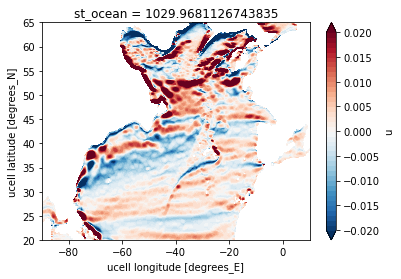

In [13]:
u_NA[28,:,:].plot.contourf(levels = np.linspace(-2e-2,2e-2,41))

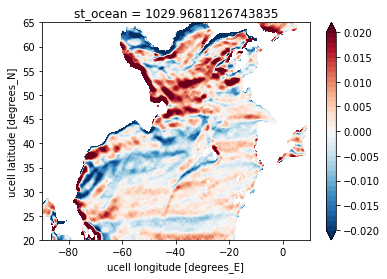

In [14]:
ugx_interp[28,:,:].plot.contourf(levels = np.linspace(-2e-2,2e-2,41))

### Calculation of Barotropic Transport

Once the x and y Geostrophic Velocities are calculated, the Geostrohic Transport is calculated, which is added to the Ekman Transport, both of which together form the Barotropic Transport.

$
\begin{equation}
    M = \int_{-H}^0 \rho \mathbf{u_G} dz + \rho_0 \mathbf{U_E}
\end{equation}
$

Ekman Transport has a certain depth, and its velocity changes magnitude and direction with depth. Usually, Ekman Transport has its effect upto 20 metres of the ocean, which induces variability and makes it difficult to obtain good estimates of velocities near the free surface. 

A part of the model testing involves the comparison between the velocities (Geostrophic + Ekman) with that obtained by running the ACCESS Model. For this, we have taken an Ekman Layer of 15 m, added the resulting Ekman Velocity to the Geostrophic velocity at the surface and tried to validate our results.

In [15]:
dMgx = rho_nil*ugx_interp*dz_interp
Mgx = np.sum(dMgx, axis = 0)
Mx_T = Uex_Array*rho_nil + Mgx

dMgy = rho_nil*ugy_interp*dz_interp
Mgy = np.sum(dMgy, axis = 0)
My_T = Uey*rho_nil + Mgy

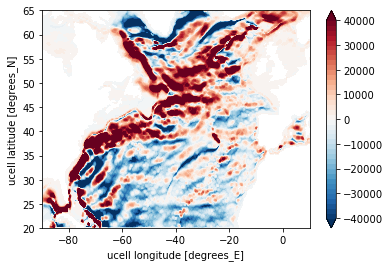

In [16]:
Mx_T.plot.contourf(levels = np.linspace(-4e4,4e4,41))

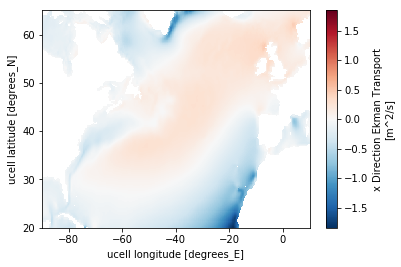

In [17]:
Uex_Array.plot()

In [18]:
ugx_interp.xu_ocean.shape

(401,)

### Poisson Solver for Barotropic Streamfunction

In [19]:
#264*401 equations in 0.25 degree model
#89*121 equations in 1 degree model

Mx_T = Mx_T.chunk(chunks ={'yu_ocean' : 264,'xu_ocean' : 401})
My_T = My_T.chunk(chunks ={'yu_ocean' : 264,'xu_ocean' : 401})
RHS = ((My_T*np.cos(My_T.yu_ocean*np.pi/180)).differentiate('xu_ocean')*(180/np.pi) - Mx_T.differentiate('yu_ocean')*(180/np.pi))*r0



In [20]:
#x_u_NA_temp = x_u_NA.ffill(0)
dxu_left = x_u_NA[1:-1].values - x_u_NA[0:-2].values
dxu_right = x_u_NA[2:].values - x_u_NA[1:-1].values
dyu_left = y_u_NA[1:-1].values - y_u_NA[0:-2].values
dyu_right = y_u_NA[2:].values - y_u_NA[1:-1].values
dxu_array = (dxu_right + dxu_left)/2
dyu_array = (dyu_right + dyu_left)/2
dxu_DA = xr.DataArray(dxu_array, coords = [x_u_NA[1:-1]], dims = ['xu_ocean'], 
                          name = 'dxu in Coordinates', attrs = {'units':'none'})
dyu_DA = xr.DataArray(dyu_array, coords = [y_u_NA[1:-1]], dims = ['yu_ocean'], 
                          name = 'dyu in Coordinates', attrs = {'units':'none'})

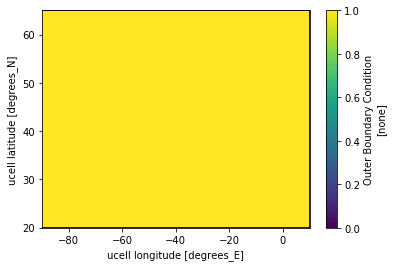

In [21]:
#Creating a mask for outer boundary equal to zero for Sverdrup relation

ny = 264
nx = 401
temp = np.ones((ny,nx))
temp[0,:] = np.zeros(nx)
temp[ny-1,:] = np.zeros(nx)
temp[:,0] = np.zeros(ny)
temp[:,nx-1] = np.zeros(ny)
mask_Outer = xr.DataArray(temp,  coords = [y_u_NA,x_u_NA], dims = ['yu_ocean','xu_ocean'], 
                          name = 'Outer Boundary Condition', attrs = {'units':'none'})
del temp
mask_Outer.plot()

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/dask/array/blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.04/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


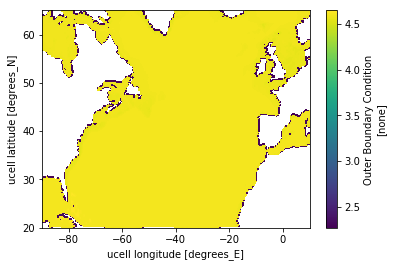

In [22]:
#Creating a mask for the boundary of North Atlantic Ocean

temp1 = dz_interp[0,:,:].ffill('yu_ocean',limit = 1)
temp1 = temp1.bfill('yu_ocean',limit = 1)
temp2 = dz_interp[0,:,:].ffill('xu_ocean',limit = 1)
temp2 = temp2.bfill('xu_ocean',limit = 1)
temp1 = temp1.fillna(0)
temp2 = temp2.fillna(0)
temp = temp1+temp2
temp_arr = temp.values
temp_arr[temp_arr == 0] = np.nan
temp = xr.DataArray(temp_arr,  coords = [y_u_NA,x_u_NA], dims = ['yu_ocean','xu_ocean'], 
                          name = 'Outer Boundary Condition', attrs = {'units':'none'})
temp.plot()

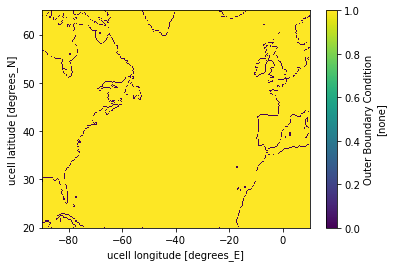

In [23]:
temp3 = xr.ufuncs.isnan(dz_interp[0,:,:])
temp3 = temp3.astype(int)
mask = temp3*temp
mask_arr = mask.values
mask_arr[mask_arr == 0] = np.nan
np.nan_to_num(mask_arr,copy = False)
mask_arr[mask_arr != 0] = 1
mask_arr[mask_arr == 0] = 2
mask_arr[mask_arr == 1] = 0
mask_arr[mask_arr == 2] = 1

#mask_arr[mask_arr == 2] = 1
mask = xr.DataArray(mask_arr,  coords = [y_u_NA,x_u_NA], dims = ['yu_ocean','xu_ocean'], 
                          name = 'Outer Boundary Condition', attrs = {'units':'none'})
mask.plot()
del(temp1)
del(temp2)
del(temp3)
del(temp)

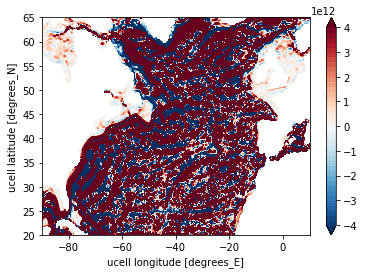

In [24]:
RHS.plot.contourf(levels = np.linspace(-4e12,4e12,41))

In [25]:
dyu_array

array([0.23445546, 0.23409867, 0.23373853, 0.23337505, 0.23300828,
       0.23263823, 0.23226495, 0.23188845, 0.23150877, 0.23112593,
       0.23073998, 0.23035094, 0.22995883, 0.22956369, 0.22916556,
       0.22876445, 0.22836041, 0.22795345, 0.22754363, 0.22713095,
       0.22671546, 0.22629719, 0.22587617, 0.22545242, 0.22502599,
       0.2245969 , 0.22416518, 0.22373087, 0.22329399, 0.22285459,
       0.22241268, 0.2219683 , 0.22152149, 0.22107227, 0.22062068,
       0.22016675, 0.21971051, 0.21925198, 0.21879121, 0.21832823,
       0.21786306, 0.21739574, 0.2169263 , 0.21645477, 0.21598118,
       0.21550557, 0.21502796, 0.21454839, 0.21406688, 0.21358348,
       0.2130982 , 0.21261109, 0.21212217, 0.21163148, 0.21113903,
       0.21064488, 0.21014904, 0.20965154, 0.20915242, 0.20865172,
       0.20814945, 0.20764564, 0.20714034, 0.20663357, 0.20612535,
       0.20561572, 0.20510472, 0.20459236, 0.20407867, 0.2035637 ,
       0.20304746, 0.20252999, 0.20201131, 0.20149146, 0.20097

In [30]:
c_test = 1
niter = 4000
conv = 0.001
count = 0
ny = 264
nx = 401
DX, DY = np.meshgrid(dxu_array,dyu_array)
#np.nan_to_num(DX,copy = False)
#np.nan_to_num(DY,copy = False)
RHS = RHS.fillna(0)
psinew = np.ones((ny,nx))
psiold = -np.ones((ny,nx)) * 10**8
while count<niter:
    psiold = psiold*mask[:,:].values*mask_Outer.values
    psinew[1:-1,1:-1] = (1/(2/((DX*(np.pi/180))**2) + 2/((DY*(np.pi/180))**2))) * ((psiold[2:,1:-1] + psiold[0:-2,1:-1])/((DX*(np.pi/180))**2) + (psiold[1:-1,2:] + psiold[2:,1:-1])/((DY*(np.pi/180))**2) - RHS[1:-1,1:-1])
    psiold = psinew.copy()
    count = count + 1
    print(count)

1
3956


KeyboardInterrupt: 

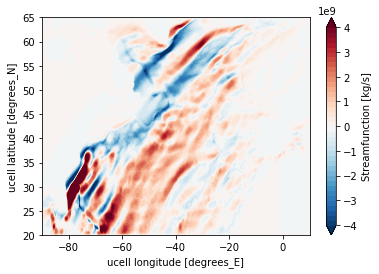

In [29]:
#1000 iterations
psiold_DA = xr.DataArray(psiold, coords = [y_u_NA, x_u_NA],  dims = ['yu_ocean', 'xu_ocean'], 
                            name = 'Streamfunction', attrs = {'units':'kg/s'})
psiold_DA.plot.contourf(levels = np.linspace(-4e9,4e9,41))

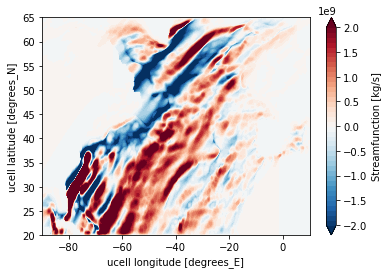

In [35]:
#3820 iterations
psiold_DA = xr.DataArray(psiold, coords = [y_u_NA, x_u_NA],  dims = ['yu_ocean', 'xu_ocean'], 
                            name = 'Streamfunction', attrs = {'units':'kg/s'})
psiold_DA.plot.contourf(levels = np.linspace(-2e9,2e9,41))

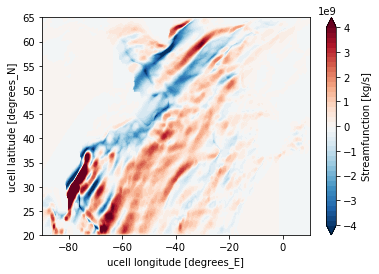

In [36]:
#3820 iterations
psiold_DA = xr.DataArray(psiold, coords = [y_u_NA, x_u_NA],  dims = ['yu_ocean', 'xu_ocean'], 
                            name = 'Streamfunction', attrs = {'units':'kg/s'})
psiold_DA.plot.contourf(levels = np.linspace(-4e9,4e9,41))